In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

from tonic.io import read_configobj
from da_utils import remap_con

In [15]:
# ================================================ #
# Command line arguments
# ================================================ #
cfg = read_configobj(('cfg/prepare_meas_error.ArkRed.NLDAS2.LAI_from_veglib.v1.cfg'))

In [16]:
# ================================================ #
# Extract dimension info
# ================================================ #
# --- Load VIC param file --- #
ds_param = xr.open_dataset(cfg['VIC']['vic_param_nc'])
# --- Extract dimension info needed --- #
lat_coord = ds_param['lat'].values
lon_coord = ds_param['lon'].values
# --- Load SMAP domain info --- #
da_smap_domain = xr.open_dataset(cfg['REMAP']['smap_domain'])[cfg['REMAP']['smap_domain_varname']]

In [17]:
# ================================================ #
# Calculate average LAI for each SMAP grid cell
# ================================================ #
da_lai_vic = (ds_param['LAI'] * ds_param['Cv']).sum(dim='veg_class').mean(dim='month')
da_lai_smap, weight_array = remap_con(reuse_weight=True, da_source=da_lai_vic,
    final_weight_nc=cfg['REMAP']['weight_nc'], da_target_domain=da_smap_domain)

Reusing weights: /civil/hydro/ymao/data_assim/output/meas_SMAP/ArkRed/NLDAS2/tmp/vic_to_smap_weights.no_split.nc


In [5]:
da_lai_smap_veglib = da_lai_smap.copy(deep=True)

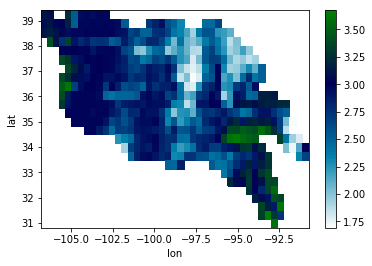

In [12]:
da_lai_smap_veglib.plot(cmap='ocean_r')

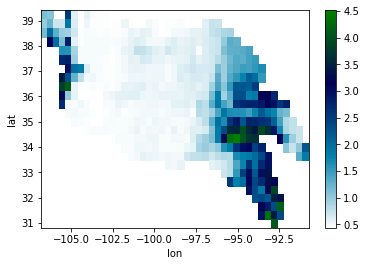

In [13]:
da_lai_smap.plot(cmap='ocean_r')

In [18]:
# Save remapped LAI to file
ds_lai_smap = xr.Dataset({'LAI': da_lai_smap})
lai_out_nc = os.path.join(os.path.dirname(cfg['VIC']['vic_param_nc']),
                          'ArkRed.LAI.veglib.nc')
ds_lai_smap.to_netcdf(lai_out_nc, format='NETCDF4_CLASSIC')

In [19]:
da_lai_smap.sel(lat=slice(35.5, 35.2), lon=slice(-98.8, -98.4))

<xarray.DataArray (lat: 1, lon: 2)>
array([[1.997776, 2.261799]])
Coordinates:
  * lat      (lat) float32 35.335194
  * lon      (lon) float32 -98.77593 -98.40249

In [20]:
da_lai_smap.sel(lat=slice(35, 34.7), lon=slice(-98.2, -97.9))

<xarray.DataArray (lat: 1, lon: 1)>
array([[2.353265]])
Coordinates:
  * lat      (lat) float32 34.991234
  * lon      (lon) float32 -98.029045

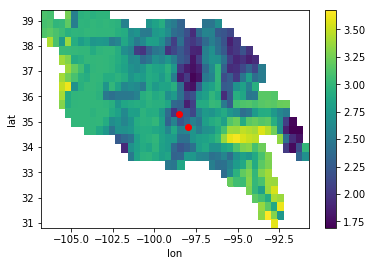

In [22]:
# --- Plot LAI --- #
da_lai_smap.plot()
plt.scatter([-98.5], [35.3], c='r')
plt.scatter([-98], [34.8], c='r')

(array([ 9., 10., 14., 15., 12., 19., 21., 32., 37., 35., 53., 52., 86.,
        77., 30., 15., 17., 14.,  6.,  6.]),
 array([1.69102   , 1.79017709, 1.88933418, 1.98849127, 2.08764835,
        2.18680544, 2.28596253, 2.38511962, 2.48427671, 2.5834338 ,
        2.68259089, 2.78174797, 2.88090506, 2.98006215, 3.07921924,
        3.17837633, 3.27753342, 3.3766905 , 3.47584759, 3.57500468,
        3.67416177]),
 <a list of 20 Patch objects>)

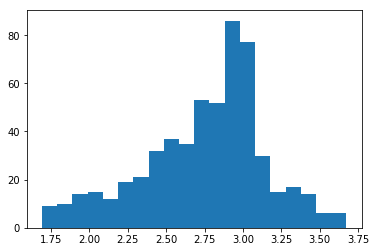

In [23]:
# --- Some plotting --- #
lai_all_values = da_lai_smap.values.flatten()[~np.isnan(da_lai_smap.values.flatten())]
plt.hist(lai_all_values, bins=20)

In [10]:
(lai_all_values>1).sum()

189

In [28]:
# ================================================ #
# Calculate unscaled measurement error
# ================================================ #
# # Version 1:
# # Linearly scale LAI of range [min(LAI), 1] to measurement error [0.03, 0.05] mm/mm
# # Locations of LAI > 1 is set to error = 0.05 mm/mm
# lai_smap = da_lai_smap.values
# lai_smap[lai_smap>1] = 1
# da_lai_smap_max1 = da_lai_smap.copy(deep=True)
# da_lai_smap_max1[:] = lai_smap
# da_meas_error_unscaled = (0.05 - (1 - da_lai_smap_max1) / (1 - da_lai_smap_max1.min()) * 0.02)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [53]:
# # Version 2
# # Piecewise linear mapping based on LAI:
# #     If LAI in range [min(LAI), 0.5], map to measurement error [0.025, 0.05] mm/mm
# #     If LAI in range [0.5, 2], map to measurement error [0.05, 0.15] mm/mm
# #     If LAI > 2, set to measurement error = 0.15 mm/mm
# # This mapping makes the SMAP core sites have approximately consistent error
# # with those reported in Colliander et al. 2017; all the sites the paper reported
# # globally range within ~[0.025, 0.12] mm/mm, thus here I set the maximum to be
# # 0.15 mm/mm

# lai_smap = da_lai_smap.values
# meas_error_unscaled = np.empty(lai_smap.shape)
# meas_error_unscaled[:] = np.nan
# # First piecewise linear
# lai_min = float(da_lai_smap.min().values)
# slope1 = (0.05 - 0.025) / (0.5 - lai_min)
# meas_error_unscaled[lai_smap<=0.5] = \
#     0.025 + (lai_smap[lai_smap<=0.5] - lai_min) * slope1
# # Second piecewise linear
# slope2 = (0.15 - 0.05) / (2 - 0.5)
# meas_error_unscaled[(lai_smap>0.5) & (lai_smap<=2)] = \
#     0.05 + (lai_smap[(lai_smap>0.5) & (lai_smap<=2)] - 0.5) * slope2
# # Third piecewise linear (constant)
# meas_error_unscaled[lai_smap>2] = 0.15
# # Put in xr.DataArray
# da_meas_error_unscaled = da_lai_smap.copy(deep=True)
# da_meas_error_unscaled[:] = np.nan
# da_meas_error_unscaled[:] = meas_error_unscaled
# 
# # --- Plot mapping relationship --- #
# fig = plt.figure(figsize=(8, 4))
# plt.plot([lai_min, 0.5], [0.025, 0.05], 'b-')
# plt.plot([0.5, 2], [0.05, 0.15], 'b-')
# plt.plot([2, float(da_lai_smap.max().values)], [0.15, 0.15], 'b-')
# plt.xlabel('LAI (from VIC parameters)', fontsize=16)
# plt.ylabel('Mapped SMAP error (mm/mm)', fontsize=16)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [16]:
# # ================================================ #
# # Calculate unscaled measurement error
# # ================================================ #
# # Version 3:
# # Linearly scale LAI of range [min(LAI), 0.8] to measurement error [0.025, 0.06] mm/mm
# # Locations of LAI > 0.8 is set to error = 0.06 mm/mm
# lai_smap = da_lai_smap.values
# lai_smap[lai_smap>0.8] = 0.8
# da_lai_smap_max1 = da_lai_smap.copy(deep=True)
# da_lai_smap_max1[:] = lai_smap
# da_meas_error_unscaled = \
#     (0.06 - (0.8 - da_lai_smap_max1) / (0.8 - da_lai_smap_max1.min()) * (0.06 - 0.025))

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [44]:
# ================================================ #
# Based on LAI_FROM_VEGLIB
# ================================================ #
# Version 1:
# Linearly scale LAI of range [min(LAI), max(LAI)] to measurement error [0.03, 0.045] mm/mm
lai_smap = da_lai_smap.values
slope = (0.045 - 0.03) / (da_lai_smap.max().values - da_lai_smap.min().values)
da_meas_error_unscaled = \
        0.03 + (da_lai_smap - da_lai_smap.min().values) * slope\

# Use the same SMAP linear relation to map VIC-resolution-LAI to measruement error
da_meas_error_unscaled_8th = \
        0.03 + (da_lai_vic - da_lai_smap.min().values) * slope\

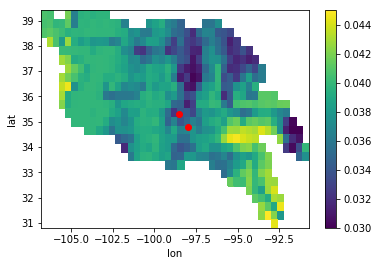

In [51]:
# --- Plot resulting meas error --- #
da_meas_error_unscaled.plot()
plt.scatter([-98.5], [35.3], c='r')  # ~ Fort Cobb
plt.scatter([-98], [34.8], c='r')  # ~ Little Watasha

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


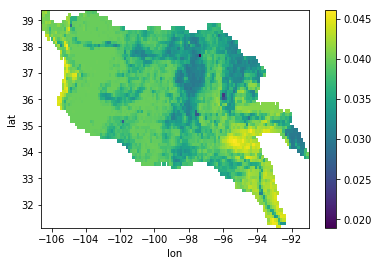

In [50]:
da_meas_error_unscaled_8th.where(da_lai_vic>0).plot()

'/civil/hydro/ymao/data_assim/tools/prepare_perturbation/output/meas_error.ArkRed.LAI_from_veglib.v1.8th.nc'

In [54]:
# ================================================ #
# Save da_meas_error_unscaled to file
# ================================================ #
# Save SMAP-resolution error
ds_meas_error_unscaled = xr.Dataset({'sm_error_unscaled': da_meas_error_unscaled})
ds_meas_error_unscaled.to_netcdf(cfg['OUTPUT']['meas_error_nc'], format='NETCDF4_CLASSIC')
# Save 1/8th-resolution error
ds_meas_error_unscaled_8th = xr.Dataset({'sm_error_unscaled': da_meas_error_unscaled_8th})
ds_meas_error_unscaled_8th.to_netcdf(
    cfg['OUTPUT']['meas_error_nc'].replace('.nc', '.8th.nc'),
    format='NETCDF4_CLASSIC')

In [22]:
# --- load std ratio --- #
da_std_ratio = xr.open_dataset(
    '/civil/hydro/ymao/data_assim/output/meas_SMAP/ArkRed/'
    'NLDAS2.weight_no_split.qc.meas_error_v2/data_scaled/'
    'std_ratio.moment_2nd_season.no_winter.20150331_20171231.nc')['std_ratio_vic_to_smap']

In [36]:
# --- Mask out bad cells manually --- #
da_smap_unscaled = xr.open_dataset(
    '/civil/hydro/ymao/data_assim/output/meas_SMAP/ArkRed/'
    'NLDAS2.weight_no_split.qc.meas_error_v2/data_unscaled/'
    'soil_moisture_unscaled.qc_no_winter.20150331_20171231.nc')['soil_moisture']

In [42]:
smap_std = da_smap_unscaled.std(dim='time', ddof=0).values

In [45]:
std_ratio = da_std_ratio.values
std_ratio[smap_std<0.01] = np.nan

In [46]:
# --- rescale error --- #
da_meas_error_scaled = da_meas_error_unscaled * da_std_ratio
da_meas_error_scaled.attrs['unit'] = 'mm'

In [53]:
# --- Save rescaled error to file --- #
ds_meas_error_scaled = xr.Dataset({'soil_moisture_error': da_meas_error_scaled})
ds_meas_error_scaled.to_netcdf('/civil/hydro/ymao/data_assim/output/meas_SMAP/ArkRed/'
                               'NLDAS2.weight_no_split.qc.meas_error_v2/data_scaled/'
                               'soil_moisture_error_scaled.moment_2nd_season.no_winter.20150331_20171231.meas_error_v3.nc')

In [47]:
da_meas_error_scaled.min()

<xarray.DataArray ()>
array(0.951718)

In [48]:
da_std_ratio.max()

<xarray.DataArray 'std_ratio_vic_to_smap' ()>
array(146.745172)